# A Basic Model From Built in Modules

Here I explore the same data I used for my "from scratch" exercises to play with build in models provied by PyTorch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

## The Data

For this exercies I generated some "known" measurments in Celcius, along with some measurments in "uknown" units.

My goal wil be to build a machine learning model from scratch that will illustrate how the process works to learn a pattern from this data to create a model.

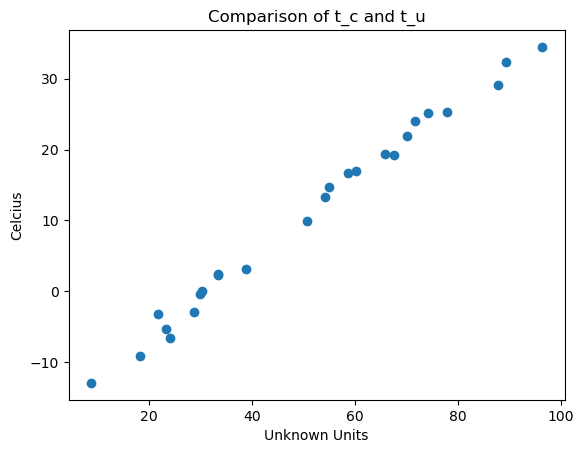

In [2]:
def simulate_temperature_data(random_state=123321, num_pts=25):
    ## Simulate a set of num_pts measurments with
    ## t_c being a "known" celcius value and
    ## t_u being the measurments in "uknown" units (Farenheit with noise)
    
    rng = np.random.RandomState(123321)
    ## Generate some celcius temps between -15 and 50 
    t_c = rng.rand(num_pts) * 50 - 15
    ## Generate corresponsing data in "unknown" units
    #°F = (°C × 9/5) + 32 + noise
    noise = rng.rand(num_pts)*10 - 5
    t_u = t_c*(9/5) + 32 + noise

    return t_c, t_u

## Generate data
t_c, t_u = simulate_temperature_data()
## Plot the data
plt.scatter(t_u,t_c)
plt.xlabel("Unknown Units")
plt.ylabel("Celcius")
plt.title("Comparison of t_c and t_u")
plt.show()

In [3]:
## Prepare the data
def prepare_data(t_c, t_u, valid_pct=0.2):
    ## Takes the t_c, t_u numpy arrays
    ## Returns a set of PyTorch arrays for training and validation
    ## Sets aside valid_pct of the data for validation
    t_c = torch.tensor(t_c).unsqueeze(1)
    t_u = torch.tensor(t_u).unsqueeze(1)
    
    ## Scale the input data
    t_un = 0.1*t_u

    ## Get the number of samples
    n_samples = t_u.shape[0]

    ## Determine the size of the validation set
    n_val = int(valid_pct*n_samples)

    ## Grab n_val random indices
    shuffled_indices = torch.randperm(n_samples)
    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    ## Gather up training and validation sets
    t_c_train = t_c[train_indices]
    t_c_val = t_c[val_indices]
    
    t_u_train = t_u[train_indices]
    t_u_val = t_u[val_indices]
    
    t_un_train = t_un[train_indices]
    t_un_val = t_un[val_indices]

    return (t_c_train, t_c_val, 
            t_u_train, t_u_val, 
            t_un_train, t_un_val)
    
t_c_train, t_c_val, t_u_train,\
    t_u_val, t_un_train, t_un_val = prepare_data(t_c, t_u)

## A Linear Model
As before, we use a linear model first.

In [4]:
## Insantiate the model, specifying inpyt/output dimension and data type
linear_model = nn.Linear(1,1, dtype=torch.float64)

## Evaluate the model on normalized inputs
linear_model(t_un_val)

tensor([[-1.6713],
        [-5.6334],
        [-3.1905],
        [-2.9005],
        [-1.4425]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [5]:
## Peek at weights and bias
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.7098]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.7008], dtype=torch.float64, requires_grad=True))

In [6]:
linear_model.parameters??

Signature: linear_model.parameters(recurse: bool = True) -> Iterator[torch.nn.parameter.Parameter]
Source:   
    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        r"""Returns an iterator over module parameters.

        This is typically passed to an optimizer.

        Args:
            recurse (bool): if True, then yields parameters of this module
                and all submodules. Otherwise, yields only parameters that
                are direct members of this module.

        Yields:
            Parameter: module parameter

        Example::

            >>> # xdoctest: +SKIP("undefined vars")
            >>> for param in model.parameters():
            >>>     print(type(param), param.size())
            <class 'torch.Tensor'> (20L,)
            <class 'torch.Tensor'> (20L, 1L, 5L, 5L)

        """
        for name, param in self.named_parameters(recurse=recurse):
            yield param
File:      ~/miniconda3/envs/torch/lib/python3.11/site-packages/to

In [8]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7098]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.7008], dtype=torch.float64, requires_grad=True)]

## Set up a training loop

In [9]:
def training_loop(n_epochs,
                  optimizer, model, loss_fn, 
                  t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        ## Training set
        t_p_train = model(t_u_train) ## Make a prediction
        loss_train = loss_fn(t_p_train, t_c_train) ## Compute the loss

        ## Validation set
        t_p_val = model(t_u_val) ## Make a predicton
        loss_val = loss_fn(t_p_val, t_c_val) ## Compute the loss

        ## Update params
        optimizer.zero_grad() ## Reset accumulated gradient
        loss_train.backward() ## Update the gradient at the training input
        optimizer.step() ## Step the params in the direction of the gradient

        if (epoch <= 5) or (epoch % 500 == 0):
            print(f"Epoch: {epoch}, Training loss: {loss_train.item():.4f},"
                  f"Validation loss: {loss_val.item():.4f}")

In [10]:
## Define the model
linear_model = nn.Linear(1,1, dtype=torch.float64)

## Define an optimizer
optimizer = optim.SGD(
    linear_model.parameters(), ## What to optimize
    lr = 1e-2 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = linear_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1, Training loss: 277.3848,Validation loss: 243.2859
Epoch: 2, Training loss: 87.2077,Validation loss: 60.5421
Epoch: 3, Training loss: 64.0486,Validation loss: 39.1205
Epoch: 4, Training loss: 60.8744,Validation loss: 36.5329
Epoch: 5, Training loss: 60.0942,Validation loss: 36.0414
Epoch: 500, Training loss: 3.0748,Validation loss: 1.1052
Epoch: 1000, Training loss: 1.8701,Validation loss: 1.1265
Epoch: 1500, Training loss: 1.8456,Validation loss: 1.2357
Epoch: 2000, Training loss: 1.8451,Validation loss: 1.2534
Epoch: 2500, Training loss: 1.8451,Validation loss: 1.2560
Epoch: 3000, Training loss: 1.8451,Validation loss: 1.2563
Epoch: 3500, Training loss: 1.8451,Validation loss: 1.2564
Epoch: 4000, Training loss: 1.8451,Validation loss: 1.2564
Epoch: 4500, Training loss: 1.8451,Validation loss: 1.2564
Epoch: 5000, Training loss: 1.8451,Validation loss: 1.2564

Parameter containing:
tensor([[5.5831]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-17.70

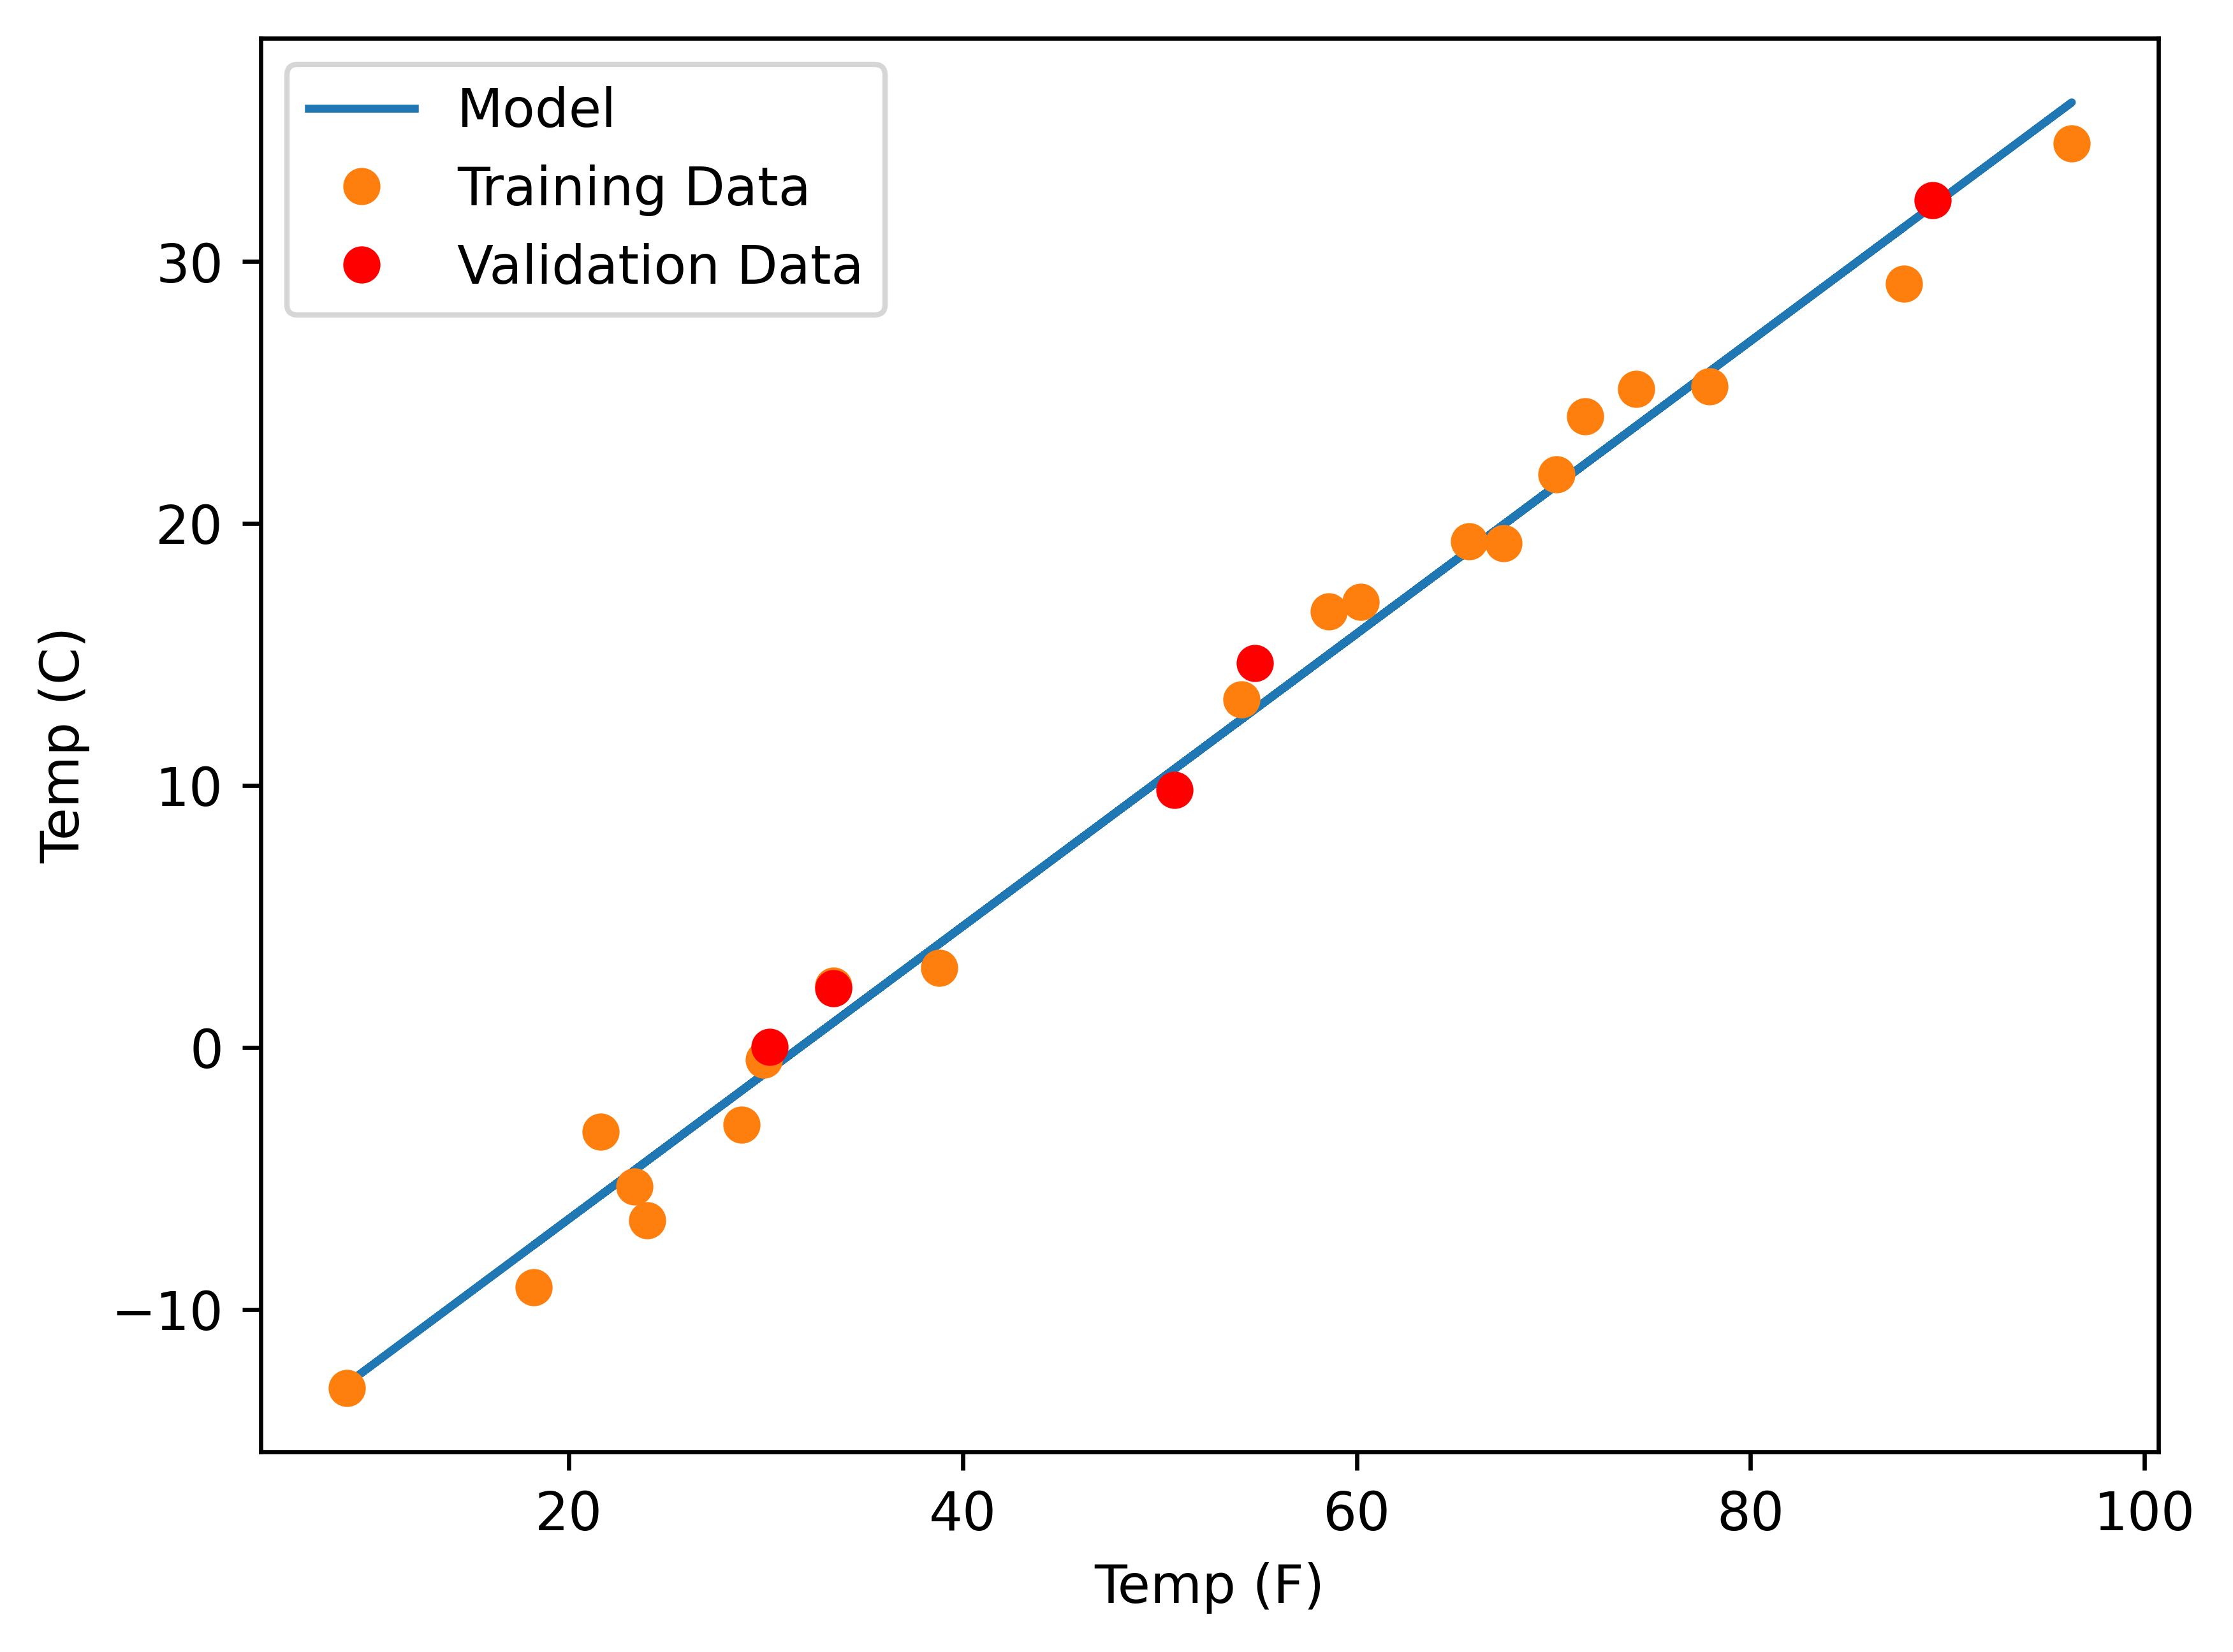

In [23]:
## Plot the results
t_p_train = linear_model(t_un_train)
fig = plt.figure(dpi=600)
plt.xlabel("Temp (F)")
plt.ylabel("Temp (C)")
plt.plot(t_u_train.numpy(), t_p_train.detach().numpy(), label="Model")
plt.plot(t_u_train.numpy(), t_c_train.numpy(), 'o', label="Training Data")
plt.plot(t_u_val.numpy(), t_c_val.numpy(), 'ro', label="Validation Data")
plt.legend()
plt.show()